# SHUBHAM SHARMA
## 18$i$190002
## MS.c. Ph.D.(OR)

This is a basic code for prediction of the situation recognition project

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# For plotting, arrays and other things
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import json

#For Deep learning 
import keras
from keras import callbacks 
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import LSTM, TimeDistributed , RepeatVector, Embedding, Reshape, concatenate
from keras.optimizers import RMSprop,SGD, adam #Optimizers
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
#Loading the datasets
X_images = np.load('gdrive/My Drive/Situation_recognition/data/X.npy')
ind_to_verbs = np.load('gdrive/My Drive/Situation_recognition/data/ind_to_verbs.npy',allow_pickle=True).item()
ind_to_nouns = np.load('gdrive/My Drive/Situation_recognition/data/ind_to_nouns.npy',allow_pickle=True).item()
list_of_actions = np.load('gdrive/My Drive/Situation_recognition/data/list_of_actions.npy',allow_pickle=True)

In [0]:
def fusion_network(width, height, depth, classes,weightsPath=None):
  
  bn_flag = True
  inputs = Input((width, height , depth))
  conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = BatchNormalization(axis = -1)(conv1,training=bn_flag)
  conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
  conv1 = BatchNormalization(axis= -1)(conv1,training=bn_flag)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  ##
  conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = BatchNormalization(axis = -1)(conv2,training=bn_flag)
  conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
  conv2 = BatchNormalization(axis= -1)(conv2,training=bn_flag)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  ##
  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = BatchNormalization(axis = -1)(conv3,training=bn_flag)
  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
  conv3 = BatchNormalization(axis = -1)(conv3,training=bn_flag)
  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
  conv3 = BatchNormalization(axis = -1)(conv3,training=bn_flag)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  ##
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = BatchNormalization(axis = -1)(conv4,training=bn_flag)
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
  conv4 = BatchNormalization(axis = -1)(conv4,training=bn_flag)
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
  conv4 = BatchNormalization(axis = -1)(conv4,training=bn_flag)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  ##
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = BatchNormalization(axis = -1)(conv5,training=bn_flag)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
  conv5 = BatchNormalization(axis = -1)(conv5,training=bn_flag)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
  conv5 = BatchNormalization(axis = -1)(conv5,training=bn_flag)
  pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
  ##
  Y = Flatten()(pool5)
  Y = Dense(4096, activation='relu')(Y)
  Y = Dense(4096, activation='relu')(Y)
  Y = Dense(4096, activation='relu')(Y)
  out = Dense(classes, activation='softmax')(Y)
  
  model = Model(inputs=[inputs], outputs=[out])
  
  if weightsPath is not None:
    model.load_weights(weightsPath)
    
  print(model.summary())
  return model 
  
  
def prediction_network(width, height, depth, verb_length = 1, num_verbs = 50, hidden_layer = 3500, encoding_nodes = 4096, weightsPath=None):
  
  bn_flag = True
  inputs_to_vgg = Input((width, height , depth))
  conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs_to_vgg)
  conv1 = BatchNormalization(axis = -1)(conv1,training=bn_flag)
  conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
  conv1 = BatchNormalization(axis= -1)(conv1,training=bn_flag)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  ##
  conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = BatchNormalization(axis = -1)(conv2,training=bn_flag)
  conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
  conv2 = BatchNormalization(axis= -1)(conv2,training=bn_flag)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  ##
  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = BatchNormalization(axis = -1)(conv3,training=bn_flag)
  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
  conv3 = BatchNormalization(axis = -1)(conv3,training=bn_flag)
  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
  conv3 = BatchNormalization(axis = -1)(conv3,training=bn_flag)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  ##
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = BatchNormalization(axis = -1)(conv4,training=bn_flag)
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
  conv4 = BatchNormalization(axis = -1)(conv4,training=bn_flag)
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
  conv4 = BatchNormalization(axis = -1)(conv4,training=bn_flag)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  ##
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = BatchNormalization(axis = -1)(conv5,training=bn_flag)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
  conv5 = BatchNormalization(axis = -1)(conv5,training=bn_flag)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
  conv5 = BatchNormalization(axis = -1)(conv5,training=bn_flag)
  pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
  ##
  Y = Flatten()(pool5)
  Y = Dense(hidden_layer, activation='relu')(Y)
  Y = Dense(hidden_layer, activation='relu')(Y)
  Y = Dense(hidden_layer, activation='relu')(Y)
  Y = Reshape((1,hidden_layer))(Y)

  ####################################################################################################
  # Y is the output from the VGG network. Now let us make an output from the verb and concatenate them 
  input_verb = Input([verb_length])
  Z = Embedding(num_verbs, hidden_layer)(input_verb)
  
  input_to_lstm = concatenate([Z , Y],axis = 1)
  encoder = LSTM(encoding_nodes)(input_to_lstm)
  
  L = RepeatVector(39)(encoder)
  L = LSTM(2310 , return_sequences = True )(L)
  out = TimeDistributed(Dense(2310, activation = 'softmax'))(L)
  

  model = Model(inputs=[inputs_to_vgg , input_verb], outputs=[out])
  
  if weightsPath is not None:
    model.load_weights(weightsPath)
    
  print(model.summary())
  return model


fusion = fusion_network(width = 256, height = 256, depth = 3, classes = 50 , weightsPath='gdrive/My Drive/Situation_recognition/fusion')












Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 12

In [0]:
prediction_net = prediction_network(width = 256, height = 256, depth = 3, verb_length = 1,  weightsPath='gdrive/My Drive/Situation_recognition/situation2.h5')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 256, 256, 64) 256         conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 64) 36928       batch_normalization_14[0][0]     
____________________________________________________________________________________________

In [0]:
imsitu = json.load(open('gdrive/My Drive/Situation_recognition/data/imsitu_space.json'))
nouns = imsitu["nouns"]
def predict_fusion(i):
  Z = X_images[i]
  Z = np.reshape(Z,(1,Z.shape[0],Z.shape[1],Z.shape[2]))
  
  prob_fusion = fusion.predict(Z)
  prediction_fusion = np.argmax(prob_fusion,axis=1)
  return prediction_fusion

def predict_nouns(i):
  Z = X_images[i]
  img_input = np.reshape(Z,(1,Z.shape[0],Z.shape[1],Z.shape[2]))
  S = predict_fusion(i)
  verb_input = np.reshape(S,(1,S.shape[0]))

  prob_situation = prediction_net.predict([img_input, verb_input])
  prediction_nouns = np.argmax(prob_situation,axis=2)
  return prediction_nouns

def predict_output(i):
  verb_output = predict_fusion(i)
  verb = ind_to_verbs[verb_output[0]]
  ##
  noun_output = predict_nouns(i)
  noun_output = noun_output.reshape(-1)
  result_with_all_actions = {list_of_actions[i]:ind_to_nouns[noun_output[i]] for i in range(len(list_of_actions))}
  print(result_with_all_actions)
  result_nouns ={}
  for i in list_of_actions:
    if result_with_all_actions[i]!='':
      result_nouns[i] = nouns[result_with_all_actions[i]]['gloss']

  return verb , result_nouns

{'agent': 'n10287213', 'agentpart': '', 'beneficiary': '', 'bodypart': '', 'cause': '', 'coagent': '', 'components': '', 'connector': '', 'container': '', 'createditem': '', 'crop': '', 'destination': '', 'dirt': '', 'end': '', 'experiencer': '', 'gatherers': '', 'giver': '', 'goal': '', 'interviewee': '', 'item': 'n14942762', 'item1': '', 'item2': '', 'liquid': '', 'listener': '', 'object': '', 'obstacle': '', 'perceiver': '', 'place': 'n08613733', 'recipient': '', 'restrained': '', 'source': '', 'start': '', 'substance': '', 'surface': '', 'target': '', 'tool': '', 'vehicle': '', 'victim': '', 'victimpart': ''}
The verb is: chopping
the corresponding actions and nouns are: {'agent': ['man', 'adult male'], 'item': ['log'], 'place': ['outdoors', 'out-of-doors', 'open air', 'open']}


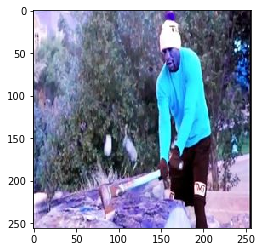

In [0]:
i = np.random.randint(len(X_images))
# print(i)
verb,nouns_out = predict_output(i)
plt.imshow(X_images[i])
print('The verb is:',verb)
print('the corresponding actions and nouns are:',nouns_out)

In [0]:
i = np.random.randint(len(X_images))
predict_nouns(i)


array([[   3,    0,    0,    0,    0,    0,    0, 2226,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 2303,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  978,    0,    0,    0]])